# 序列模型

In [2]:
#使用正弦函数和一些可加性噪声来生成序列数据， 时间步为1, 2, 3, ..., 1000
import torch
from torch import nn
from d2l import torch as d2l

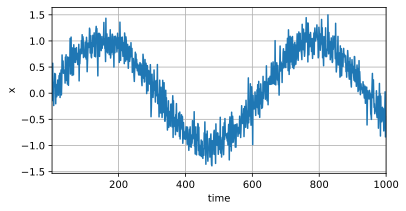

In [4]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [6]:
# 转换成特征－标签对
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [8]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [10]:
# 使用两个全连接层的多层感知机，ReLU激活函数和平方损失
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [12]:
# 训练
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.075590
epoch 2, loss: 0.055628
epoch 3, loss: 0.054848
epoch 4, loss: 0.051874
epoch 5, loss: 0.050966


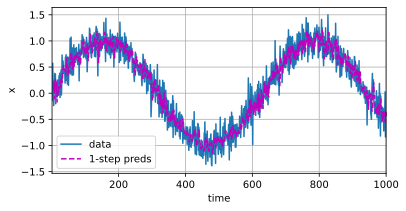

In [14]:
# 单步预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))


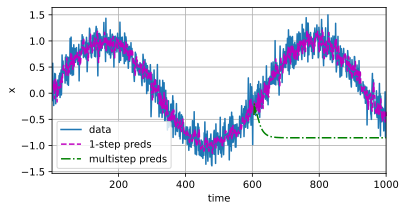

In [16]:
# 多步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
为什么这个算法效果这么差呢？事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。
于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。
因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，
但超过这一点，精度就会迅速下降。

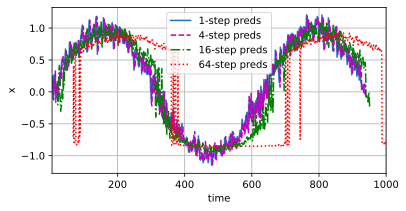

In [19]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
    steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

在序列模型中，多步预测质量很差主要是由以下原因导致的：
- **误差累积**：随着预测步数的增加，每一步的预测误差会不断累积。就像滚雪球一样，初始的小误差会在后续的预测中逐渐放大，导致最终的预测结果与实际值相差甚远。例如，在对时间序列数据进行预测时，第一步预测的小偏差可能会在第二步的预测中被进一步放大，因为第二步的预测是基于第一步的结果进行的，以此类推，误差会越来越大。
- **信息损失**：在序列模型中，随着时间步的推移，早期的数据信息在模型中会逐渐被稀释或遗忘。模型在进行多步预测时，可能无法充分利用最初观测到的数据中的关键信息，从而影响预测的准确性。特别是对于长序列数据，模型很难记住所有的细节，导致在多步预测时丢失了一些对准确预测至关重要的信息。
- **不确定性增加**：未来的情况往往具有更高的不确定性，预测的时间跨度越大，不确定性就越高。序列模型在面对这种不确定性时，很难准确地捕捉到各种复杂的变化因素。例如，在经济领域中，对未来几个月的经济指标进行预测可能相对较为准确，但如果要预测几年后的经济情况，由于受到众多未知因素的影响，如政策变化、突发事件等，预测的质量就会大大降低。